In [71]:
#external stuff
import h5py
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
import cv2
import numpy as np
import math
import mahotas
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from scipy.spatial import Voronoi, voronoi_plot_2d
import traceback
from uuid import uuid4 as unique_identifier
import random
import os
from time import perf_counter
from glob import glob
import pandas as pd
from scipy.optimize import linear_sum_assignment

from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import timm

#internal stuff
from contour_impl import do_contour_create, do_contour_compare
from imageprocessing import maybetogray,maybetocolor, image_preprocess, canny, recenter
from aberrations import aberrations

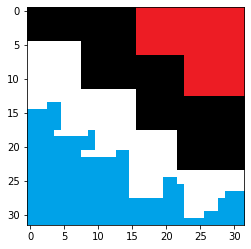

In [10]:
# load some test images
img_files=["stairtest.png","stairtest2.png","cornertest.png","cornertest2.png","cornertest3.png","cornertest4.png","tdl.png","tdl2.png","tokyo.png","tokyo2.png"]
test_images=[cv2.cvtColor(cv2.imread(iname), cv2.COLOR_BGR2RGB) for iname in img_files]
plt.imshow(test_images[0])
img=test_images[0]

In [17]:
orb = cv2.ORB_create()
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
img2 = cv2.resize(img,None, fx=13, fy=13, interpolation=cv2.INTER_AREA)
kp1, des1 = orb.detectAndCompute(img2,None)

matches = matcher.match(des1,des1)

In [63]:
kp1
[i.angle for i in kp1] # different angles
[i.class_id for i in kp1] # all -1
[i.octave for i in kp1] # increasing order
[i.response for i in kp1] # how strong the keypoint is
[i.pt for i in kp1] # pairs of coordinates
def pair_round(p):
    return (round(p[0]),round(p[1]))
[pair_round(i.pt) for i in kp1]

def orb_points_n(orb, img, n):
    img2 = cv2.resize(img,None, fx=13, fy=13, interpolation=cv2.INTER_AREA)
    kp1, des1 = orb.detectAndCompute(img2,None)
    kp1_idxs = list(range(len(kp1)))
    kp2 = sorted(kp1,key=lambda i: -i.response)
    if n==-1:
        return kp2
    return kp2[0:n]
def orb_points_p(orb, img, p):
    img2 = cv2.resize(img,None, fx=13, fy=13, interpolation=cv2.INTER_AREA)
    kp1, des1 = orb.detectAndCompute(img2,None)
    kp1_idxs = list(range(len(kp1)))
    kp2 = sorted(kp1,key=lambda i: -i.response)
    s=np.quantile([i.response for i in kp2], p)
    return np.array(kp2)[[i.response for i in kp2]<=s]
k=orb_points_p(orb,img,0.5)

In [69]:
v=Voronoi([i.pt for i in k])

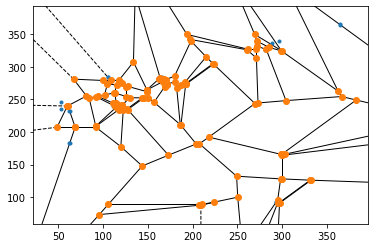

In [72]:
fig = voronoi_plot_2d(v)

In [75]:
k[v.regions[2]]

array([<KeyPoint 000001EDCE388150>, <KeyPoint 000001EDCE19F8D0>,
       <KeyPoint 000001EDCE388C30>, <KeyPoint 000001EDE1FBF450>],
      dtype=object)